# Load data

In [1]:
def extract_latent_space(data, model):
    model.eval()
    bio_z, mu1, logvar1, batch_z, mu2, logvar2, bio_batch_pred, batch_batch_pred, reconstruction = model(data)
    z1 = bio_z
    z2 = batch_z
    return z1.detach().cpu().numpy(), z2.detach().cpu().numpy(), reconstruction.detach().cpu().numpy()

In [4]:
import sys
import os
import importlib

scib_path = '../scib'
if scib_path not in sys.path:
    sys.path.append(scib_path)

import scib
importlib.reload(scib)

print(scib.__file__)

import torch
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# load data
table = pd.read_csv("/home/haiping_liu/code/data/test_data/IMMUcan_batch.csv")

data = table.iloc[:, 0:40].values 
batch_id =  pd.Categorical(table.iloc[:, 41]).codes
cell_type = table.iloc[:, 40].values 

cell_x = table["cell_x"].values
cell_y = table["cell_y"].values
image_number = table["image_number"].values

adata = sc.AnnData(data)  
adata.obs['batch'] =  pd.Categorical(batch_id.astype(str))
adata.obs['celltype'] = pd.Categorical(cell_type.astype(str))

sc.pp.subsample(adata, fraction=0.5)
sc.pp.neighbors(adata, use_rep='X')  
sc.tl.umap(adata) 
sc.settings.set_figure_params(fontsize=12)  
sc.pl.umap(adata, color=['BATCH', 'celltype'] , title="UMAP - Batch ID", size=3)
plt.show()

## Inference and visulization

In [7]:
import sys
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))

if project_root not in sys.path:
    sys.path.append(project_root)

from models.model import IMCVAE
from utils.dataset import GeneralDataset

In [74]:
import torch
import numpy as np
from torch.utils.data import DataLoader

# load model
checkpoint_path = '/home/haiping_liu/code/My_model/BioBatchNet/saved/models/IMMU/0119_220333/checkpoint-epoch50.pth'
checkpoint = torch.load(checkpoint_path)
config = checkpoint['config']._config if hasattr(checkpoint['config'], '_config') else checkpoint['config']
config_args = config['arch']['args']
model = IMCVAE(**config_args)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

dataset = GeneralDataset('IMMU')
dataloader = DataLoader(dataset, batch_size=256)

features_list = []
cell_types = []
latent = []
batch_ids = []
z2_list = []

model.eval()
model.to('cuda') 
with torch.no_grad():
    for batch in dataloader:
        features, batch_id, cell_type = batch
        features = features.to('cuda')
        cell_type = cell_type.to('cuda')
        batch_id = batch_id.to('cuda')
        z1, z2, recon = extract_latent_space(features, model)

        features = features.cpu().numpy()
        features_list.append(features)
        latent.append(z1)
        z2_list.append(z2)
        cell_types.append(cell_type.cpu().numpy())
        batch_ids.append(batch_id.cpu().numpy())

features_combined = np.concatenate(features_list, axis=0)
latent =  np.concatenate(latent, axis=0)
cell_types = np.concatenate(cell_types, axis=0)
batch_ids = np.concatenate(batch_ids, axis=0)
z2_list = np.concatenate(z2_list, axis=0)

cell_type_names = dataset.cell_type_names
cell_types_named = [cell_type_names[code] for code in cell_types]

adata_z1 = sc.AnnData(latent)
adata_z1.obs['batch'] = pd.Categorical(batch_ids.astype(str))  
adata_z1.obs['celltype'] = pd.Categorical(cell_types_named)  

# Create AnnData object
immu_adata = sc.AnnData(X=features_combined) 
immu_adata.obs['BATCH'] = pd.Categorical(batch_ids.astype(str)) 
immu_adata.obs['celltype'] = pd.Categorical(cell_types_named) 
# immu_adata.obsm['X_berd'] = latent 

/tmp/ipykernel_25547/295360396.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
/tmp/ipykernel_25547/295360396.py:11: FutureWarni

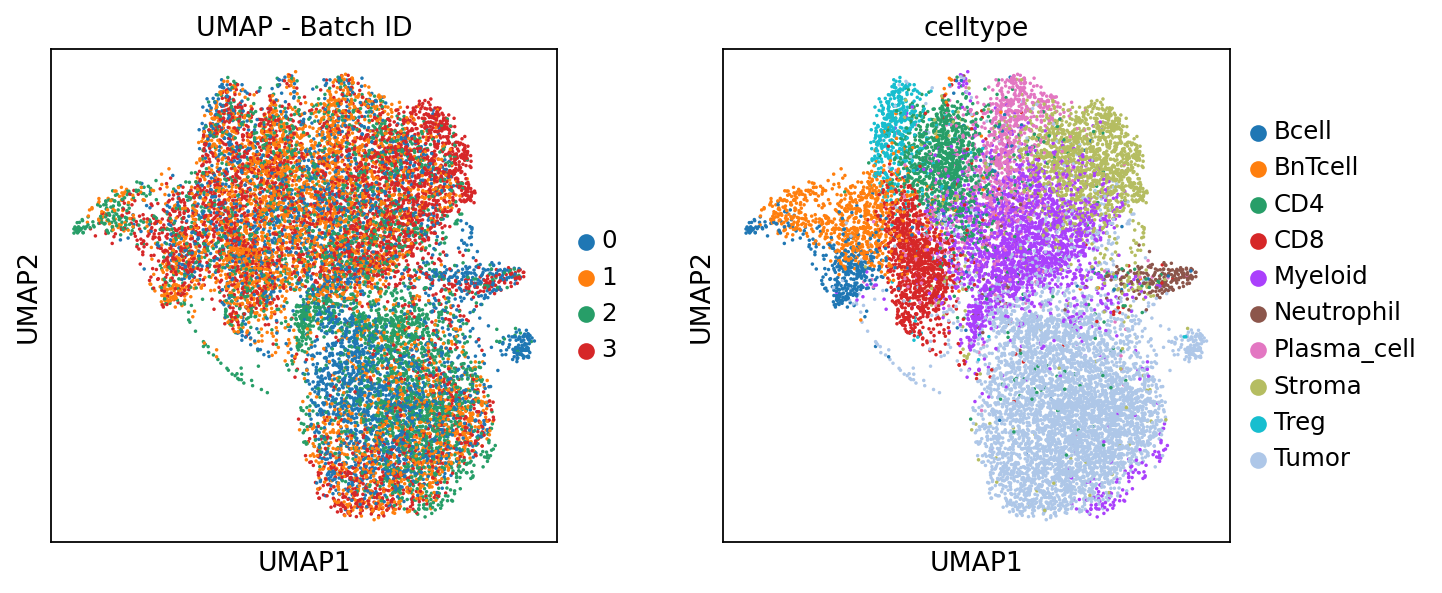

In [75]:
sc.pp.subsample(adata_z1, fraction=0.3)
sc.pp.neighbors(adata_z1, use_rep='X')  
sc.tl.umap(adata_z1) 
sc.pl.umap(adata_z1, color=['batch', 'celltype'] , title="UMAP - Batch ID", size=10)
plt.show()

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


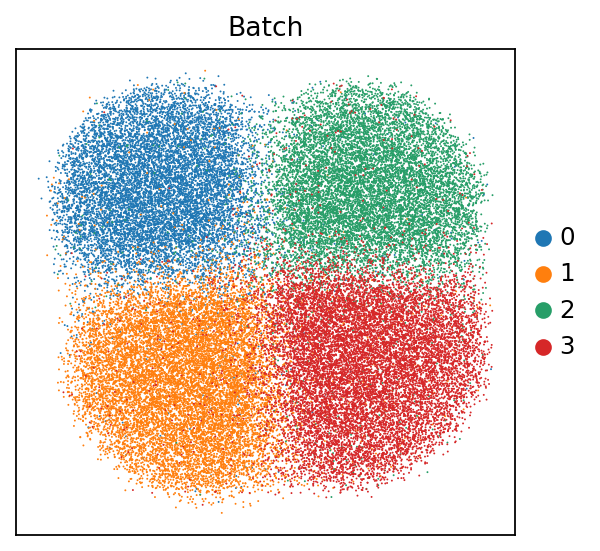

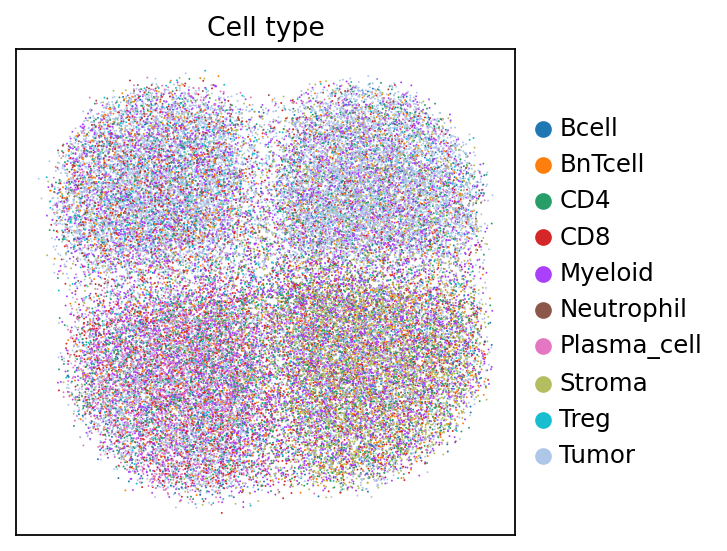

In [41]:
adata_z2 = sc.AnnData(z2_list)  
adata_z2.obs['batch'] = pd.Categorical(batch_ids.astype(str))  
adata_z2.obs['cell type'] = pd.Categorical(cell_types_named)  

# Compute neighbors and UMAP embedding
sc.pp.neighbors(adata_z2, use_rep='X')
sc.tl.umap(adata_z2)

# Set figure parameters
sc.settings.set_figure_params(fontsize=12)

# Plot the UMAP for 'batch'
fig, ax = plt.subplots()
sc.pl.umap(
    adata_z2,
    color='batch',
    title='Batch',  # Remove the title
    size=3,
    ax=ax,
    show=False  # Don't display immediately
)
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('')  # Remove y-axis label
plt.show()

# Plot the UMAP for 'cell type'
fig, ax = plt.subplots()
sc.pl.umap(
    adata_z2,
    color='cell type',
    title= 'Cell type',  # Remove the title
    size=3,
    ax=ax,
    show=False  # Don't display immediately
)
ax.set_xlabel('')  # Remove x-axis label
ax.set_ylabel('')  # Remove y-axis label
plt.show()


In [ ]:
adata_recon = sc.AnnData(recon)  
adata_recon.obs['batch'] = pd.Categorical(batch_id.astype(str))  
adata_recon.obs['cell type'] = pd.Categorical(cell_type.astype(str))

# visulization
sc.pp.neighbors(adata_recon, use_rep='X')  
sc.tl.umap(adata_recon) 
sc.settings.set_figure_params(fontsize=12)  
sc.pl.umap(adata_recon, color=['batch', 'cell type'] , title="UMAP - Batch ID", size=3)
plt.show()

## Evaluation

### 1. Batch effect

In [27]:
import scib
scib.metrics.ilisi_graph(adata_z1, batch_key='batch', type_="full")

In [18]:
scib.me.graph_connectivity(adata_z1, label_key="cell type")

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

0.9903082279405387

In [30]:
sc.pp.pca(adata_z1)
scib.me.silhouette_batch(adata_z1, batch_key="batch", label_key="cell type", embed='X_pca')

mean silhouette per group:              silhouette_score
group                        
Bcell                0.913275
BnTcell              0.940058
CD4                  0.975671
CD8                  0.980415
Myeloid              0.970946
Neutrophil           0.871743
Plasma_cell          0.957950
Stroma               0.946150
Treg                 0.963068
Tumor                0.919122


0.9438397110934451

In [99]:
# kbet
sc.pp.pca(adata_z1)
scib.me.kBET(adata_z1, batch_key="batch", label_key="celltype", type_="embed", embed="X_pca")

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a 

Adding diffusion to step 4
Adding diffusion to step 5


/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Adding diffusion to step 4


/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Adding diffusion to step 4
Adding diffusion to step 5


/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  

0.3945820030878091

In [39]:
scib.me.pcr_comparison(adata, adata_z1, covariate="batch", embed="X_pca")

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


0.8559704621439763

### 2. Biological information

In [11]:
sc.pp.neighbors(adata_z1)
scib.me.cluster_optimal_resolution(adata_z1, cluster_key="cluster", label_key="cell type")
scib.me.ari(adata_z1, cluster_key="cluster", label_key="cell type")

Cluster for cluster_0.2 with leiden


/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/clustering.py:96: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=resolution_key, **kwargs)


resolution: 0.2, nmi: 0.2646273451767027
Cluster for cluster_0.4 with leiden
resolution: 0.4, nmi: 0.4016653987554245
Cluster for cluster_0.6 with leiden
resolution: 0.6, nmi: 0.4551616570648373
Cluster for cluster_0.8 with leiden
resolution: 0.8, nmi: 0.4263668202665707
Cluster for cluster_1.0 with leiden
resolution: 1.0, nmi: 0.45171283117676997
Cluster for cluster_1.2 with leiden
resolution: 1.2, nmi: 0.420311565267027
Cluster for cluster_1.4 with leiden
resolution: 1.4, nmi: 0.4074358726803506
Cluster for cluster_1.6 with leiden
resolution: 1.6, nmi: 0.4078484164929842
Cluster for cluster_1.8 with leiden
resolution: 1.8, nmi: 0.39979499848977773
Cluster for cluster_2.0 with leiden
resolution: 2.0, nmi: 0.3948859971889134
optimised clustering against cell type
optimal cluster resolution: 0.6
optimal score: 0.4551616570648373


0.42607469595334596

In [ ]:
scib.me.nmi(adata_z1, cluster_key="cluster", label_key="cell type")

In [162]:
sc.pp.pca(adata_z1)
scib.me.silhouette(adata_z1, label_key="cell type", embed="X_pca")

0.5351101011037827

In [ ]:
scib.me.clisi_graph(adata_z1, label_key="cell type", type_="embed", use_rep="X_pca")

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


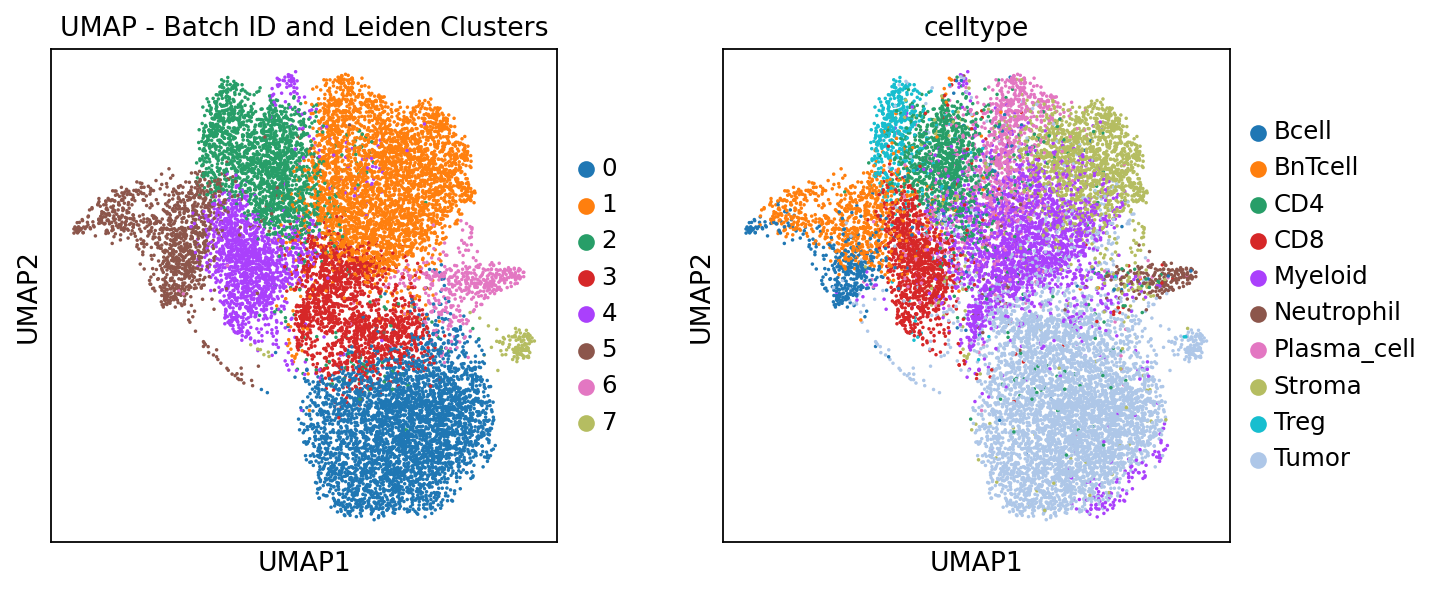

Adjusted Rand Index (ARI) score: 0.43389776666342256
Normalized Mutual Information (NMI) score: 0.48894218920935023


<Figure size 320x320 with 0 Axes>

In [80]:
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
)

sc.tl.leiden(adata_z1, resolution=0.55, key_added='leiden_clusters')
sc.settings.set_figure_params(fontsize=12)  
sc.pl.umap(adata_z1, color=['leiden_clusters', 'celltype'], title="UMAP - Batch ID and Leiden Clusters", size=10)

cell_type_labels = adata_z1.obs['celltype']
leiden_labels = adata_z1.obs['leiden_clusters']

# Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(cell_type_labels, leiden_labels)
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Normalized Mutual Information (NMI)
nmi_score = normalized_mutual_info_score(cell_type_labels, leiden_labels)
print(f"Normalized Mutual Information (NMI) score: {nmi_score}")

plt.subplots_adjust(wspace=1)
plt.show()